In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

In [2]:
from tqdm.auto import tqdm

In [3]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import json

In [4]:
import torch

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [7]:
from pts.model.hopfield import HopfieldEstimator
from pts.dataset.repository.datasets import dataset_recipes
from pts.modules import ZeroInflatedNegativeBinomialOutput, NegativeBinomialOutput
from pts import Trainer

In [8]:
dataset = get_dataset("electricity", regenerate=False)

/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/common.py:321: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/common.py:324: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/common.py:325: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


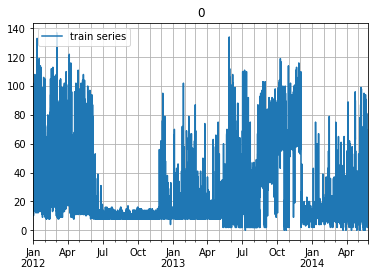

In [9]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

/mnt/scratch/kashif/gluon-ts/src/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


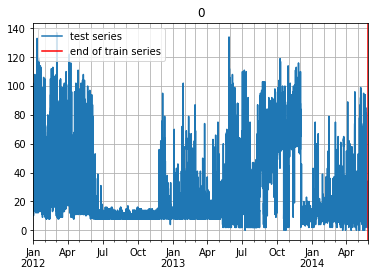

In [10]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

In [9]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 24
Frequency of the time series: 1H


In [21]:
estimator = HopfieldEstimator(
    #distr_output=ZeroInflatedNegativeBinomialOutput(),
    num_heads=3,
    act_type='relu',
    input_size=30,
    dropout_rate=0.1,
    #use_feat_dynamic_real=True,
    #use_feat_static_cat=True,
    #cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    #embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*14,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=50,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=128,)
)

In [22]:
predictor = estimator.train(dataset.train, num_workers=2, shuffle_buffer_length=1024)

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70><function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
as

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timest

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_po

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3

  0%|          | 0/99 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


In [23]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, # test dataset
    predictor=predictor, # predictor
    num_samples=100, # number of sample paths we want for evaluation
)

In [24]:
tss = list(tqdm(ts_it, total=len(dataset.test)))

  0%|          | 0/2247 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbea7c06f70>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


In [25]:
forecasts = list(tqdm(forecast_it, total=len(dataset.test)))

  0%|          | 0/2247 [00:00<?, ?it/s]

/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/mnt/scratch/kashif/gluon-ts/src/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


In [26]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|█████████████████| 2247/2247 [00:00<00:00, 4220.31it/s]/mnt/scratch/kashif/gluon-ts/src/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/mnt/scratch/kashif/gluon-ts/src/gluonts/evaluat

In [27]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4619684.686967506,
    "abs_error": 11434688.807991028,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631954,
    "seasonal_error": 189.49338196116761,
    "MASE": 0.9300631023903464,
    "MAPE": 0.12252303064987774,
    "sMAPE": 0.12917907638156154,
    "MSIS": 7.702278273280983,
    "QuantileLoss[0.1]": 4864547.2629469875,
    "Coverage[0.1]": 0.09711096276516838,
    "QuantileLoss[0.2]": 7554432.231121236,
    "Coverage[0.2]": 0.19366562824506747,
    "QuantileLoss[0.3]": 9480079.777759258,
    "Coverage[0.3]": 0.2881805370123127,
    "QuantileLoss[0.4]": 10769073.338240145,
    "Coverage[0.4]": 0.38134178905206945,
    "QuantileLoss[0.5]": 11434688.865732364,
    "Coverage[0.5]": 0.4740580032636107,
    "QuantileLoss[0.6]": 11474114.360028878,
    "Coverage[0.6]": 0.5595238095238095,
    "QuantileLoss[0.7]": 10693289.537042182,
    "Coverage[0.7]": 0.6537791128912623,
    "QuantileLoss[0.8]": 9012123.666626533,
    "Coverage[0.8]": 0.754320575582

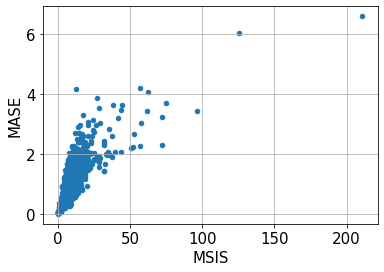

In [28]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

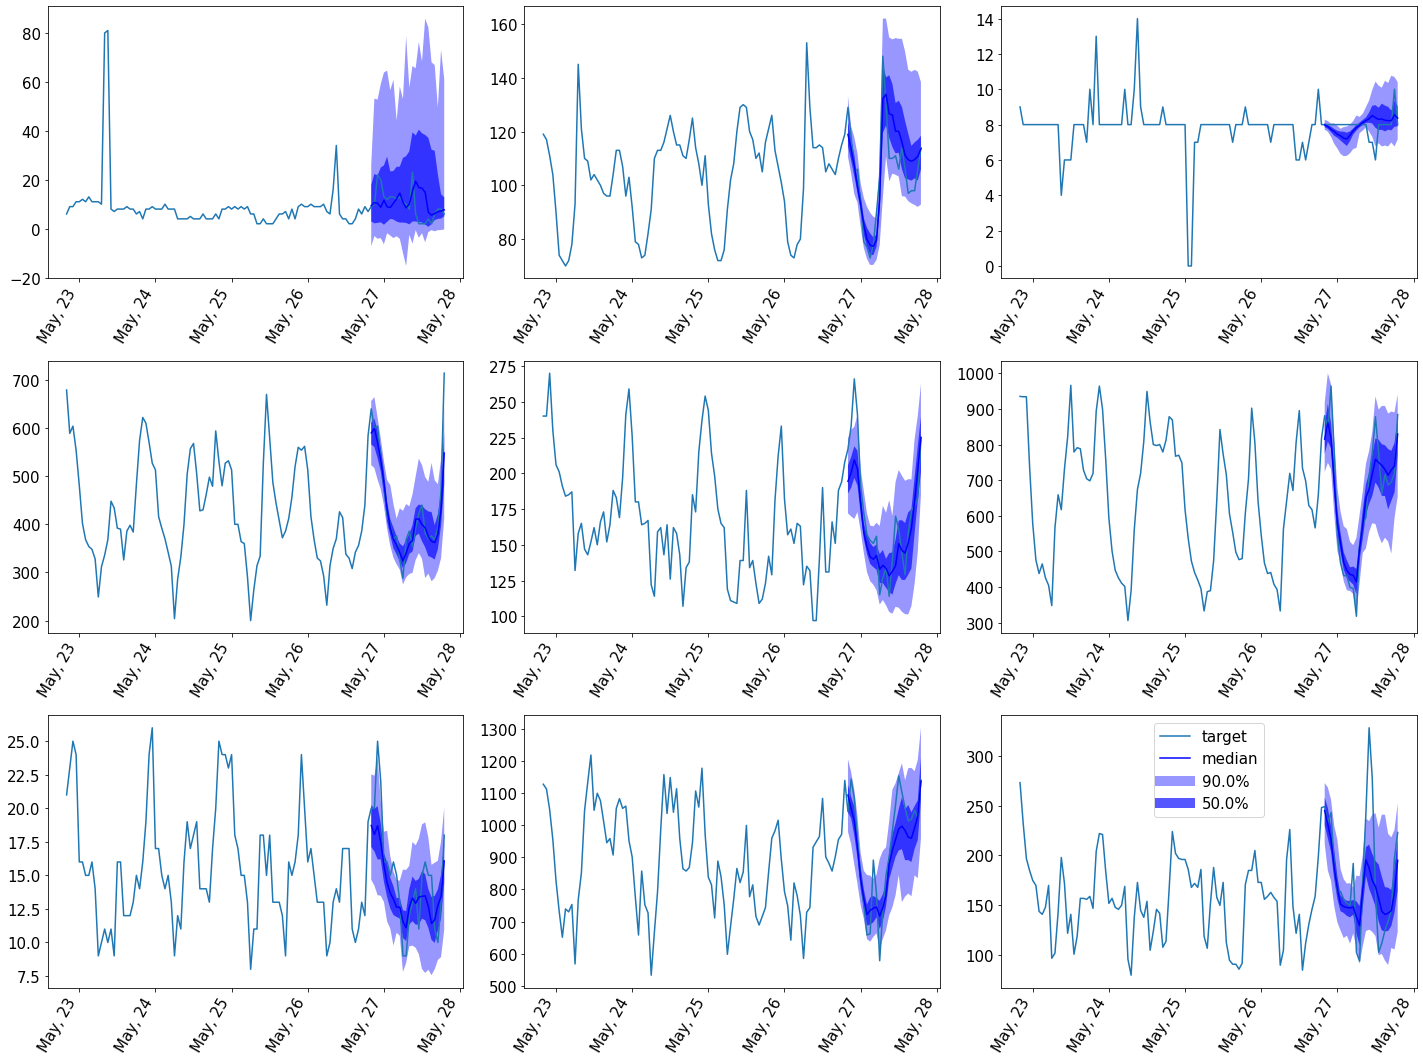

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

prediction_length = dataset.metadata.prediction_length

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()